In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely import affinity
import random
import colorsys
from datetime import datetime

In [ ]:
president_polls_url = "https://projects.fivethirtyeight.com/polls-page/data/president_polls.csv"
senate_polls_url = "https://projects.fivethirtyeight.com/polls-page/data/senate_polls.csv"
gubernatorial_polls_url = "https://projects.fivethirtyeight.com/polls-page/data/governor_polls.csv"
house_polls_url = "https://projects.fivethirtyeight.com/polls-page/data/house_polls.csv"
senate_url = "https://github.com/fivethirtyeight/election-results/raw/main/election_results_senate.csv"
president_url = "https://github.com/fivethirtyeight/election-results/raw/main/election_results_presidential.csv"
gubernatorial_url = "https://github.com/fivethirtyeight/election-results/raw/main/election_results_gubernatorial.csv"
house_url = "https://github.com/fivethirtyeight/election-results/raw/main/election_results_house.csv"
states_demographics_url = "https://corgis-edu.github.io/corgis/datasets/csv/state_demographics/state_demographics.csv"
cities_demographics_url = "https://github.com/plotly/datasets/raw/master/us-cities-top-1k.csv"


In [ ]:
keys_white_house = election_factors = {
    "Midterm gains": False,
    "No primary contest": True,
    "Incumbent seeking re-election": True,
    "No third party": True,
    "Strong short-term economy": True,
    "Strong long-term economy": True,
    "Major policy change": True,
    "No social unrest": True,
    "No scandal": True,
    "No foreign/military failure": False,
    "Major foreign/military success": False,
    "Charismatic incumbent": False,
    "Uncharismatic challenger": True
}

In [ ]:
electoral_votes = {
    "Alabama": 9,
    "Kentucky": 8,
    "North Dakota": 3,
    "Alaska": 3,
    "Louisiana": 8,
    "Ohio": 17,
    "Arizona": 11,
    "Maine": 3,
    "Maine-2": 1,
    "Oklahoma": 7,
    "Arkansas": 6,
    "Maryland": 10,
    "Oregon": 8,
    "California": 54,
    "Massachusetts": 11,
    "Pennsylvania": 19,
    "Colorado": 10,
    "Michigan": 15,
    "Rhode Island": 4,
    "Connecticut": 7,
    "Minnesota": 10,
    "South Carolina": 9,
    "Delaware": 3,
    "Mississippi": 6,
    "South Dakota": 3,
    "District of Columbia": 3,
    "Missouri": 10,
    "Tennessee": 11,
    "Florida": 30,
    "Montana": 4,
    "Texas": 40,
    "Georgia": 16,
    "Nebraska": 4,
    "Nebraska-2": 1,
    "Utah": 6,
    "Hawaii": 4,
    "Nevada": 6,
    "Vermont": 3,
    "Idaho": 4,
    "New Hampshire": 4,
    "Virginia": 13,
    "Illinois": 19,
    "New Jersey": 14,
    "Washington": 12,
    "Indiana": 11,
    "New Mexico": 5,
    "West Virginia": 4,
    "Iowa": 6,
    "New York": 28,
    "Wisconsin": 10,
    "Kansas": 6,
    "North Carolina": 16,
    "Wyoming": 3
}

top_pollsters = [
    "The New York Times/Siena College",
    "ABC News/The Washington Post",
    "Marquette University Law School",
    "YouGov",
    "Monmouth University Polling Institute",
    "Marist College",
    "Suffolk University",
    "Data Orbital",
    "University of Massachusetts Lowell Center for Public Opinion",
    "Emerson College",
    "Muhlenberg College Institute of Public Opinion",
    "Selzer & Co.",
    "University of North Florida Public Opinion Research Lab",
    "CNN",
    "SurveyUSA",
    "Beacon Research/Shaw & Co. Research",
    "Quinnipiac University",
    "MassINC Polling Group",
    "Ipsos",
    "Christopher Newport University Wason Center for Civic Leadership"
]





In [ ]:
data_buffer = {"Polling" : {},"Results" : {}, "Demography" : {}}

def loadDataInitial(types_polls = ["President", "Governor", "House", "Senate"],types_results = ["President", "Governor", "House", "Senate"], types_demographic = ["state","city"]):

    global data_buffer

    for type in types_polls:
        data_buffer["Polling"][type] = getPolling(type,use_buffer=False)

    for type in types_results:
        data_buffer["Results"][type] = getResults(type,use_buffer=False)

    for type in types_demographic:
        data_buffer["Demography"][type] = getDemographics(type,use_buffer=False)



def getPolling(type,use_buffer=True):

    if not use_buffer:

        if type == "President":
            data = pd.read_csv(president_polls_url)
        elif type == "Senate":
            data = pd.read_csv(senate_polls_url)
        elif type == "House":
            data = pd.read_csv(house_polls_url)
        elif type == "Governor":
            data = pd.read_csv(gubernatorial_polls_url)

    else:
        data = data_buffer["Polling"][type]

    return data





def getResults(type,use_buffer=True):

    if not use_buffer:

        if type == "President":
            data = pd.read_csv(president_url)
        elif type == "Senate":
            data = pd.read_csv(senate_url)
        elif type == "House":
            data = pd.read_csv(house_url)
        elif type == "Governor":
            data = pd.read_csv(gubernatorial_url)

    else:

        data = data_buffer["Results"][type]

    return data

def getDemographics(type,use_buffer=True):

    if not use_buffer:
        if type == "state":
            data = pd.read_csv(states_demographics_url)
            data.set_index("State", inplace=True)
        elif type == "city":
            data = pd.read_csv(cities_demographics_url)

    else:
        data = data_buffer["Demography"][type]

    return data



def getRecentPolling(type,state,number,party,last_date,pollster):

    data = getPolling(type)

    data['end_date'] = pd.to_datetime(data['end_date'],format='%m/%d/%y')

    # Filter the DataFrame based on the specified state, end date and party
    if pollster:
        state_df = data[(data['state'] == state) & (data['end_date'] >= pd.to_datetime(last_date, format='%m/%d/%y')) & (data['party'] == party) & ((data['stage'] == "general") | (data['stage'] == "runoff")) & (data['pollster'].isin(top_pollsters))]
    else:
        state_df = data[
            (data['state'] == state) & (data['end_date'] >= pd.to_datetime(last_date, format='%m/%d/%y')) & (data['party'] == party) & ((data['stage'] == "general") | (data['stage'] == "runoff"))]

    if type != "House":

        # Filter rows
        df = state_df.nlargest(number, 'end_date')

        polling = df['pct'].mean() if not df.empty else None

    else:

        grouped = state_df.groupby('seat_name')

        if len(grouped) == 0:
            return False

        percentage = 0
        for seat_name, group in grouped:

            percentage += pd.Series(group['pct'].tolist()[:number]).mean()

        polling = percentage / len(grouped)

    return polling


def getRecentResults(type, state, party, last_year):

    data = getResults(type)

    # Filter the DataFrame based on the specified state and party
    filtered_df = data[(data['state'] == state) & (data['ballot_party'] == party) & (data['cycle'].astype(int) >= last_year)]

    if (not data["office_seat_name"].isna().all()):

        seats = filtered_df.groupby('office_seat_name')
        # Create two different dataframes based on the cycles
        seats = [group for _, group in seats]

    else:
        seats = [filtered_df]



    #print (seats[1].to_string())

    seats_relevant = []


    for seat in seats:


        data = seat.sort_values(by='cycle', ascending=False)

        data = data[(data["cycle"] == data["cycle"].iloc[0])]

        if 'ranked_choice_round' in data.columns:
            data = data.sort_values(by='ranked_choice_round', ascending=False)
            if (not data["ranked_choice_round"].isna().all()):
                data = data[(data["ranked_choice_round"] == data["ranked_choice_round"].iloc[0])]

        runoff = data[(data["stage"] == "runoff")]
        general = data[(data["stage"] == "general")]
        jungle = data[(data["stage"] == "jungle primary")]

        if not runoff.empty:
            seats_relevant.append({"seat" : data["office_seat_name"].iloc[0], "data": runoff})
        elif not general.empty:
            seats_relevant.append({"seat": data["office_seat_name"].iloc[0], "data": general})
        elif not jungle.empty:
            seats_relevant.append({"seat": data["office_seat_name"].iloc[0], "data": jungle})
        else:
            return None

    results = []
    for cycle_data in seats_relevant:
        results.append(cycle_data["data"]['percent'].sum())

    result = sum(results) / len(results)

    return result




def getDemographyValue(state,value):

    data = getDemographics("state")

    if value == "population":
        value = "Population.2014 Population"
    if value == "under 18":
        value = "Age.Percent Under 18 Years"
    if value == "over 65":
        value = "Age.Percent 65 and Older"
    if value == "white":
        value = "Ethnicities.White Alone, not Hispanic or Latino"
    if value == "university":
        value = "Education.Bachelor's Degree or Higher"
    if value == "density":
        value = "Population.Population per Square Mile"

    if state == "national":
        result = data[value].mean()
    else:
        result = data.loc[state, value]

    #print (state, value, result)

    return result


def getPercentageBigCities(state):

    city_data = getDemographics("city")

    filtered_df = city_data[(city_data['Population'] > 100000) & (city_data['State'] == state)]

    total_value = sum(filtered_df["Population"])

    percentage = total_value / getDemographyValue(state,"population")

    return percentage


def getKeysWhiteHouse(binary = False):

    false_count = sum(value == False for value in keys_white_house.values())
    true_count = sum(value == True for value in keys_white_house.values())

    if binary:
        if false_count > 6:
            return False
        else:
            return True
    else:
        return 7.69 * (true_count - false_count)

getKeysWhiteHouse(binary=False)

def getDemographyScore(state,party, weights = {"under 18": 1.0, "over 65": 1.0, "white": 1.0, "university": 1.0, "demography": 1.0} ):

    #go back to scores but sometimes + 2?

    direction = 0

    direction += weights["under 18"] * ( getDemographyValue(state,"under 18") - getDemographyValue("national","under 18") )

    direction -= weights["over 65"] * ( getDemographyValue(state, "over 65") - getDemographyValue("national", "over 65") )

    direction -= weights["white"] * (getDemographyValue(state, "white") - getDemographyValue("national", "white"))

    direction += weights["university"] * ( getDemographyValue(state, "university") - getDemographyValue("national", "university") )

    direction += weights["demography"]  * ( (getPercentageBigCities(state) * (getDemographyValue(state,"density") / 10) - 0.219 * (getDemographyValue("national","density") / 10)))



    if party == "DEM":
        return direction
    elif party == "REP":
        return direction * -1



def load_map_data():
    fp = "us-states.json"
    data = gpd.read_file(fp)
    data = data[data['name'] != 'Puerto Rico']
    data['color'] = '#808080'

    # Identify the geometries for Alaska and Hawaii
    alaska_geometry = data[data['name'] == 'Alaska']['geometry'].iloc[0]
    hawaii_geometry = data[data['name'] == 'Hawaii']['geometry'].iloc[0]

    # Move Alaska (for example, let's move it 20 units to the right and 10 units up)
    alaska_geometry = affinity.translate(alaska_geometry, xoff=45, yoff=-35)
    alaska_geometry = affinity.scale(alaska_geometry, xfact=0.2, yfact=0.2)

    # Resize Hawaii (for example, let's scale it by a factor of 0.5)
    hawaii_geometry = affinity.translate(hawaii_geometry, xoff=50, yoff=7)

    # Update the GeoDataFrame with the modified geometries
    data.loc[data['name'] == 'Alaska', 'geometry'] = alaska_geometry
    data.loc[data['name'] == 'Hawaii', 'geometry'] = hawaii_geometry

    maine_copy = data[data['name'] == 'Maine'].copy()
    nebraska_copy = data[data['name'] == 'Nebraska'].copy()

    # Rename the copies
    maine_copy['name'] = 'Maine-2'
    nebraska_copy['name'] = 'Nebraska-2'

    # Append the new rows to the original DataFrame
    data = gpd.GeoDataFrame(pd.concat([data, maine_copy, nebraska_copy], ignore_index=True))

    return data

def color_state(data, state, color):

    data.loc[data['name'] == state, 'color'] = color
    return data

def hsl_to_hex(h, s, l):
    # Convert HSL to RGB using colorsys
    r, g, b = colorsys.hls_to_rgb(h / 360.0, l / 100.0, s / 100.0)

    # Convert the RGB values from 0-1 range to 0-255 range
    r = int(r * 255)
    g = int(g * 255)
    b = int(b * 255)

    # Format the RGB values into a hex string
    return f'#{r:02x}{g:02x}{b:02x}'


def hex_to_hsl(hex_color):
    # Convert hex color to RGB
    r = int(hex_color[1:3], 16) / 255
    g = int(hex_color[3:5], 16) / 255
    b = int(hex_color[5:7], 16) / 255

    # Convert RGB to HSL
    h, l, s = colorsys.rgb_to_hls(r, g, b)

    return round(h * 360), s, l


def draw_map(data,votes,save=""):

    # Plot the map
    fig, ax = plt.subplots(figsize=(15, 15))

    maine_edges = data[data['name'].isin(['Maine'])]
    nebraska_edges = data[data['name'].isin(['Nebraska'])]

    maine_2 = data[data['name'].isin(['Maine-2'])]
    nebraska_2 = data[data['name'].isin(['Nebraska-2'])]

    data = data[~data['name'].isin(['Maine-2', 'Nebraska-2'])]

    data.plot(ax=ax, color=data['color'],edgecolor='black')

    maine_2.plot(ax=ax, facecolor="none",edgecolor=maine_2['color'],hatch="\\")
    nebraska_2.plot(ax=ax, facecolor="none",edgecolor=nebraska_2['color'],hatch="\\")

    maine_edges.plot(ax=ax, facecolor="none",edgecolor='black')
    nebraska_edges.plot(ax=ax, facecolor="none", edgecolor='black')

    ax.set_xticks([])
    ax.set_yticks([])

    ax.text(-95, 25, f'Kamala Harris: {votes["DEM"]} Donald Trump: {votes["REP"]}', ha='center', va='center', color='black', fontsize=10, fontweight='bold')


    data = pd.concat([data, maine_2,nebraska_2], ignore_index=True)

    blue_data = data[data['color'].apply(lambda x: hex_to_hsl(x)[0] == 240)]
    red_data = data[data['color'].apply(lambda x: hex_to_hsl(x)[0] == 0 )]

    blue_data_sorted = blue_data.assign(brightness=blue_data['color'].apply(lambda x: hex_to_hsl(x)[2])).sort_values(by='brightness')
    red_data_sorted = red_data.assign(brightness=red_data['color'].apply(lambda x: hex_to_hsl(x)[2])).sort_values(by='brightness',ascending=False)

    data_sorted = pd.concat([blue_data_sorted, red_data_sorted], ignore_index=True)

    x = -127
    for index, row in data_sorted.iterrows():
        width = electoral_votes[row["name"]] / 8.6
        rect = patches.Rectangle((x, 23.5), width = width, height= 0.5, linewidth=0.0, edgecolor='black', facecolor=row["color"])
        x = x + width
        ax.add_patch(rect)

    data_sorted = data_sorted.sort_values(by='brightness', ascending=False)

    closest = data_sorted.iloc[0]["name"] + "\n" + data_sorted.iloc[1]["name"] + "\n" + data_sorted.iloc[2]["name"] + "\n" + data_sorted.iloc[3]["name"] + "\n" + data_sorted.iloc[4]["name"]

    ax.text(-71, 31, f'Closest States:\n{closest}', ha='center', va='center', color='black',fontsize=10, fontweight='bold')

    plt.title("Prediction by US States")

    if not save:
        plt.show()
    else:
        plt.savefig(save + datetime.now().strftime("%Y-%m-%d") + ".png", bbox_inches='tight')



def guessState(state, types = ["President", "Governor", "House", "Senate"], weights = "1", remove_categories=[],pollster=False):

    if weights == "1":
        weights = {'Poll': {'President': 3.922056737763325, 'Governor': 0.24377747495366536, 'House': 0.8760269469490899,'Senate': 3.2183803868768313},'Result': {'President': 5.7315133961026352, 'Governor': 1.2760668235627581, 'House': 5.218783078519769,'Senate': 0.27790176469216227},'Demography': {'under 18': 1.9620097199766293, 'over 65': 0.5206315032409361,'white': 0.3185659006039876, 'university': 1.546164521787542,'demography': 0.3995317263110895, 'total': 1.2343248401351306},'Keys': {'total': 2.300460817665445}}

    elif weights == "2":
        weights = {'Poll': {'President': 3.9745750691511543, 'Governor': 0.13226935081155497, 'House': 0.3150193544297646, 'Senate': 3.5216326485119303}, 'Result': {'President': 2.42302303963227, 'Governor': 0.5318666293062098, 'House': 3.508931285687107, 'Senate': 0.1055102316042692}, 'Demography': {'under 18': 0.9102683777955342, 'over 65': 0.2055139256586207, 'white': 0.16014942892107686, 'university': 0.585504721308541, 'demography': 0.22091321327851696, 'total': 0.5248404231099756}, 'Keys': {'total': 0.8148103523022622}}

    [weights[category].update((key, 0.0) for key in weights[category]) for category in remove_categories if category in weights]

    swing = 0

    for type in types:
        try:
            difference = getRecentPolling(type, state, 5, "DEM", "01/01/23",pollster) - getRecentPolling(type, state, 5, "REP",
                                                                                                "01/01/23",pollster)
        except:
            difference = 0

        print("Polling: ", state, type, difference)

        swing = swing + weights["Poll"][type] * difference

        try:
            difference = getRecentResults(type, state, "DEM", 2020) - getRecentResults(type, state, "REP", 2020)
        except:
            difference = 0

        print("Result :", state, type, difference)

        swing = swing + weights["Result"][type] * difference

    print(state)
    difference = getDemographyScore(state, "DEM", weights["Demography"]) - getDemographyScore(state, "REP",
                                                                                              weights["Demography"])
    print("Demograpy :", state, difference)

    swing = swing + weights["Demography"]["total"] * difference

    return swing


In [ ]:
def simulateElection(types = ["President", "Governor", "House", "Senate"],  states = electoral_votes, weights = "1",save="",remove_categories=[],pollster=False):

    data = load_map_data()

    votes = {"DEM": 0, "REP": 0}

    one_state_votes = {state: votes for state, votes in states.items() if state not in ["Maine-2", "Nebraska-2"]}

    for state in one_state_votes:

        swing = guessState(state,types,weights,remove_categories=remove_categories,pollster=pollster)

        if state == "Maine":
            if swing < 150:
                votes["REP"] += electoral_votes["Maine-2"]
                data = color_state(data, "Maine-2", hsl_to_hex(0, 100, max(-0.3 * (150 - abs(swing)) + 90, 25)))
            else:
                votes["DEM"] += electoral_votes["Maine-2"]
                data = color_state(data, "Maine-2", hsl_to_hex(240, 100, max(-0.3 * (150 - abs(swing)) + 90, 25)))


        if state == "Nebraska":
            if swing > -500:
                votes["DEM"] += electoral_votes["Nebraska-2"]
                data = color_state(data, "Nebraska-2", hsl_to_hex(240, 100, max(-0.3 * (500 - abs(swing)) + 90, 25)))
            else:
                votes["REP"] += electoral_votes["Nebraska-2"]
                data = color_state(data, "Nebraska-2", hsl_to_hex(0, 100, max(-0.3 * (500 - abs(swing)) + 90, 25)))

        if swing > 0:
            votes["DEM"] += electoral_votes[state]
            data = color_state(data, state, hsl_to_hex(240, 100, max(-0.3 * abs(swing) + 90, 25)))
        else:
            votes["REP"] += electoral_votes[state]
            data = color_state(data, state, hsl_to_hex(0, 100, max(-0.3 * abs(swing) + 90, 25)))

        print("Prediction_ ", state, swing)
        print("Current votes ", votes)

    # print (data)
    draw_map(data,votes,save)



def proposeWeights(upper_bound = 3.0):

    states = {
        "District of Columbia": 300,
         "Wyoming": -300,
        "Vermont": 300,
        "North Dakota": -300,
        "New Hampshire": 10,
        "Minnesota": 10,
        "Texas": -10,
        "Ohio": -10,
        "California": 100,
        "New Jersey": 100,
        "Louisiana": -100,
        "Idaho": -100
    }


    heavy_rep = -500
    medium_rep = -250
    light_rep = -100

    heavy_dem = 300
    medium_dem = 150
    light_dem = 50

    states = {
        "Alabama": heavy_rep,
        "Kentucky": heavy_rep,
        "North Dakota": heavy_rep,
        "Alaska": light_rep,
        "Louisiana": medium_rep,
        "Ohio": light_rep,
        "Oklahoma": heavy_rep,
        "Arkansas": heavy_rep,
        "Maryland": heavy_dem,
        "Oregon": medium_dem,
        "California": heavy_dem,
        "Massachusetts": heavy_dem,
        "Colorado": light_dem,
        "Rhode Island": medium_dem,
        "Connecticut": medium_dem,
        "Minnesota": light_dem,
        "South Carolina": light_rep,
        "Delaware": medium_dem,
        "Mississippi": medium_rep,
        "South Dakota": heavy_rep,
        "District of Columbia": heavy_dem,
        "Missouri": medium_rep,
        "Tennessee": heavy_rep,
        "Montana": medium_rep,
        "Texas": light_rep,
        "Nebraska": medium_rep,
        "Utah": medium_rep,
        "Hawaii": heavy_dem,
        "Vermont": heavy_dem,
        "Idaho": heavy_rep,
        "New Hampshire": light_dem,
        "Virginia": light_dem,
        "Illinois": medium_dem,
        "New Jersey": light_dem,
        "Washington": medium_dem,
        "Indiana": medium_rep,
        "New Mexico": light_dem,
        "West Virginia": heavy_rep,
        "Iowa": light_rep,
        "New York": medium_dem,
        "Kansas": medium_rep,
        "Wyoming": heavy_rep
    }


    m = upper_bound

    weights = {
        "Poll": {"President": random.uniform(0, m), "Governor": random.uniform(0, m), "House": random.uniform(0, m),"Senate": random.uniform(0, m)},
        "Result": {"President": random.uniform(0, m), "Governor": random.uniform(0, m), "House": random.uniform(0, m),"Senate": random.uniform(0, m)},
        "Demography": {"under 18": random.uniform(0, m),"over 65": random.uniform(0, m),"white": random.uniform(0, m),"university": random.uniform(0, m),"demography": random.uniform(0, m),"total": random.uniform(0, m)},
        "Keys": {"total": random.uniform(0,m)}
    }

    # weights = {'Poll': {'President': 3.922056737763325, 'Governor': 0.24377747495366536, 'House': 0.8760269469490899,
    #                     'Senate': 3.2183803868768313},
    #            'Result': {'President': 5.7315133961026352, 'Governor': 1.2760668235627581, 'House': 5.218783078519769,
    #                       'Senate': 0.27790176469216227},
    #            'Demography': {'under 18': 1.9620097199766293, 'over 65': 0.5206315032409361,
    #                           'white': 0.3185659006039876, 'university': 1.546164521787542,
    #                           'demography': 0.3995317263110895, 'total': 1.2343248401351306},
    #            'Keys': {'total': 2.300460817665445}}

    correct_states = 0

    while correct_states == 0:

        print(weights)

        for state in states:
            swing = guessState(state,weights = weights)
            if (states[state] > 0 and swing > states[state]) or (states[state] < 0 and swing < states[state]):
                correct_states = correct_states + 1

        print ("CORRECT: ", correct_states)
        if correct_states < len(states):
            for weight in weights:
                for type in weights[weight]:
                    #weights[weight][type] = weights[weight][type] * random.uniform(0.9, 1.1)
                    weights[weight][type] = weights[weight][type] * random.uniform(0.5, 2.0)


    print ("Final Weights:", weights)

Polling:  Alabama President -22.500000000000007
Result : Alabama President -25.461652954742462
Polling:  Alabama Governor 0
Result : Alabama Governor -37.72892064696602
Polling:  Alabama House 8.355999999999995
Result : Alabama House -37.756278393479214
Polling:  Alabama Senate 0
Result : Alabama Senate -28.047910530225536
Alabama
Demograpy : Alabama -23.608635977932117
Prediction_  Alabama -508.9817408037343
Current votes  {'DEM': 0, 'REP': 9}
Polling:  Kentucky President -23.849999999999998
Result : Kentucky President -25.9350570581364
Polling:  Kentucky Governor 3.819999999999993
Result : Kentucky Governor 0
Polling:  Kentucky House 0
Result : Kentucky House -32.82304655116881
Polling:  Kentucky Senate 0
Result : Kentucky Senate -21.57526642810207
Kentucky
Demograpy : Kentucky -37.7044956368736
Prediction_  Kentucky -465.08871028886654
Current votes  {'DEM': 0, 'REP': 17}
Polling:  North Dakota President -25.859999999999992
Result : North Dakota President -33.357286377995635
Polling

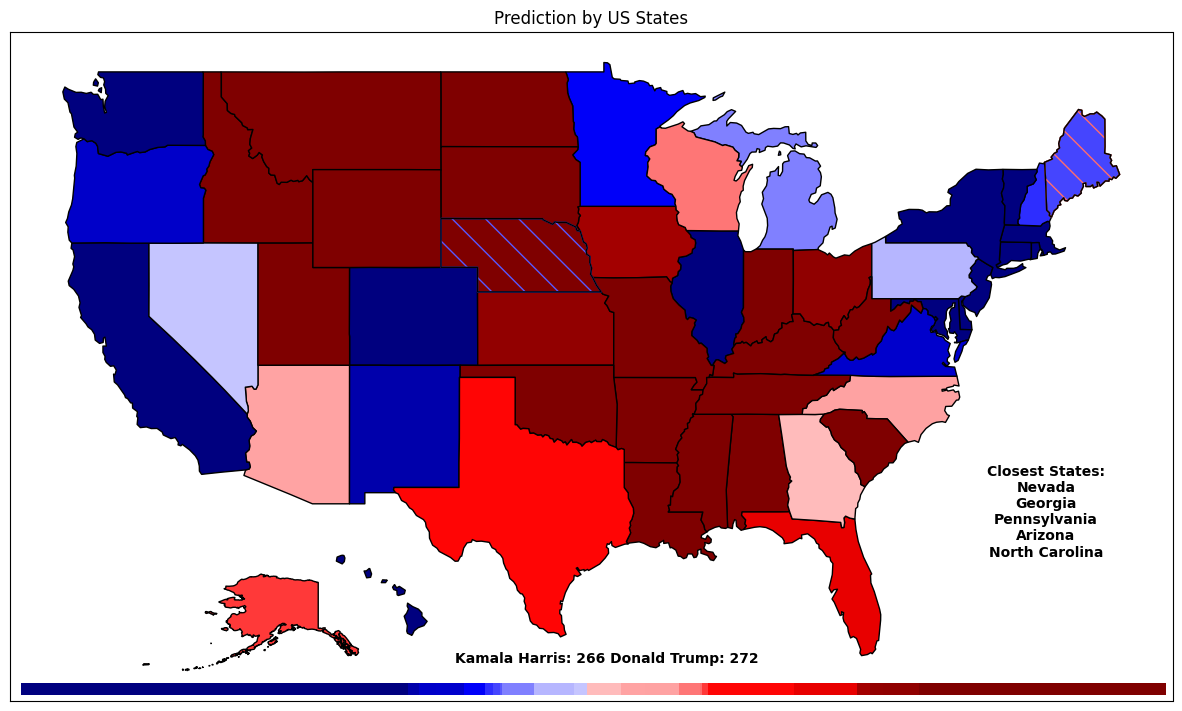

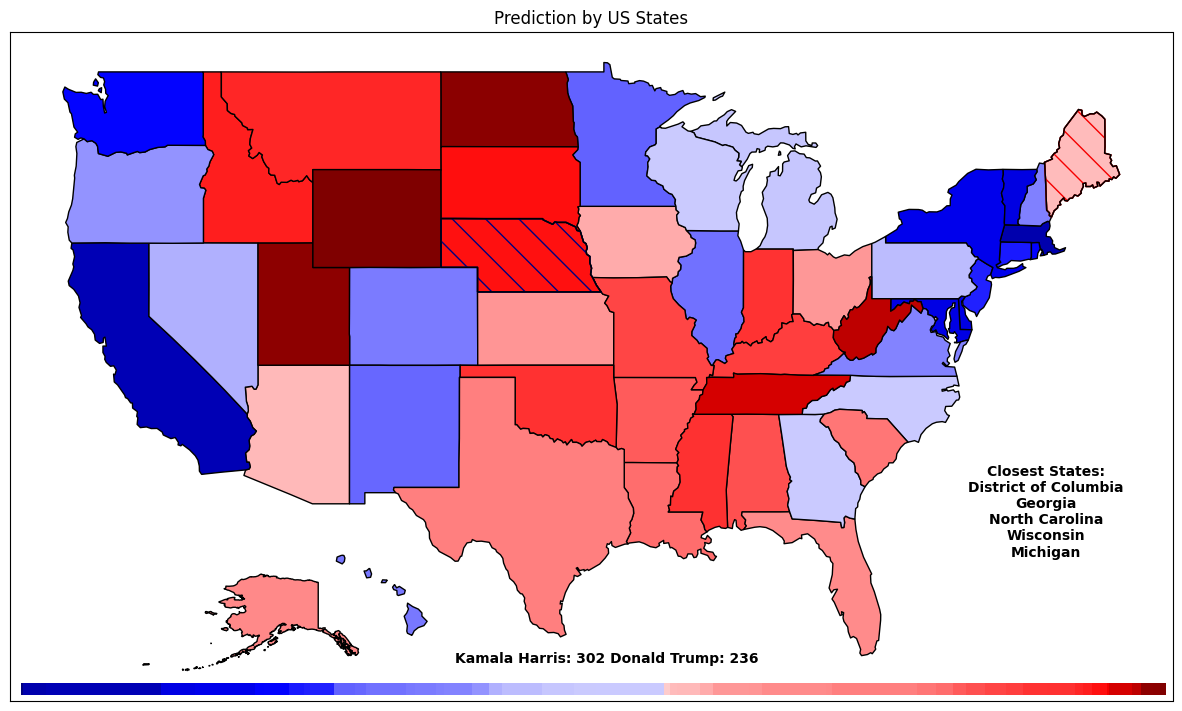

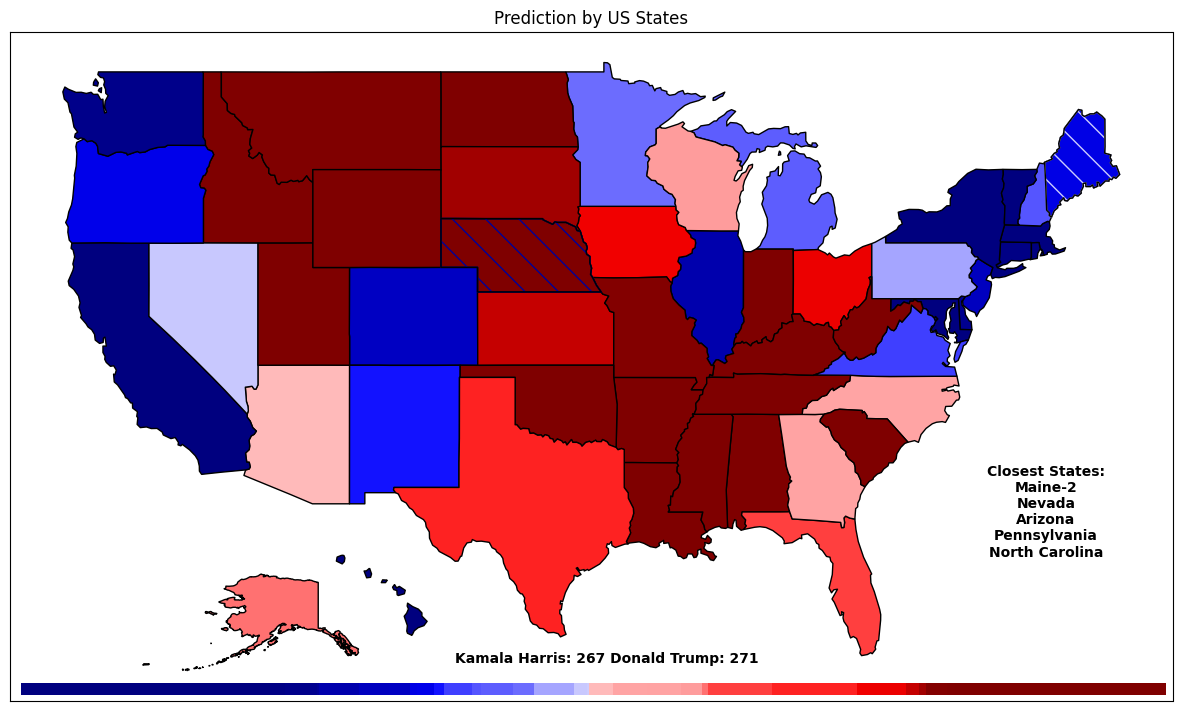

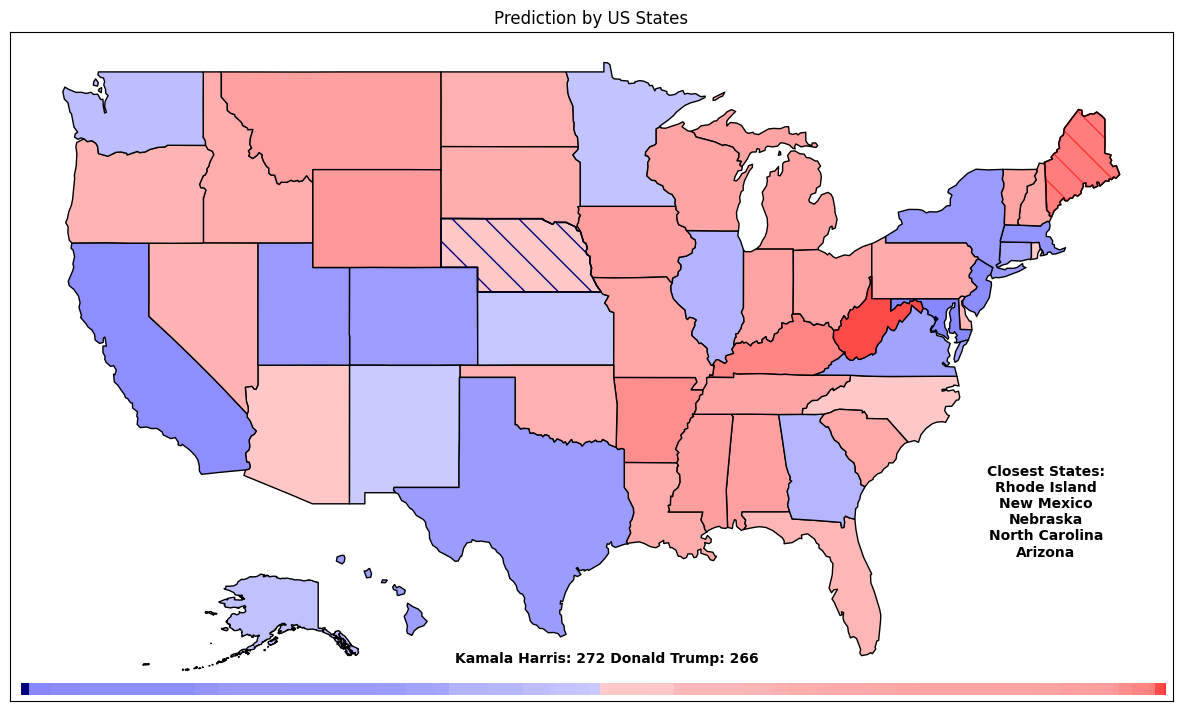

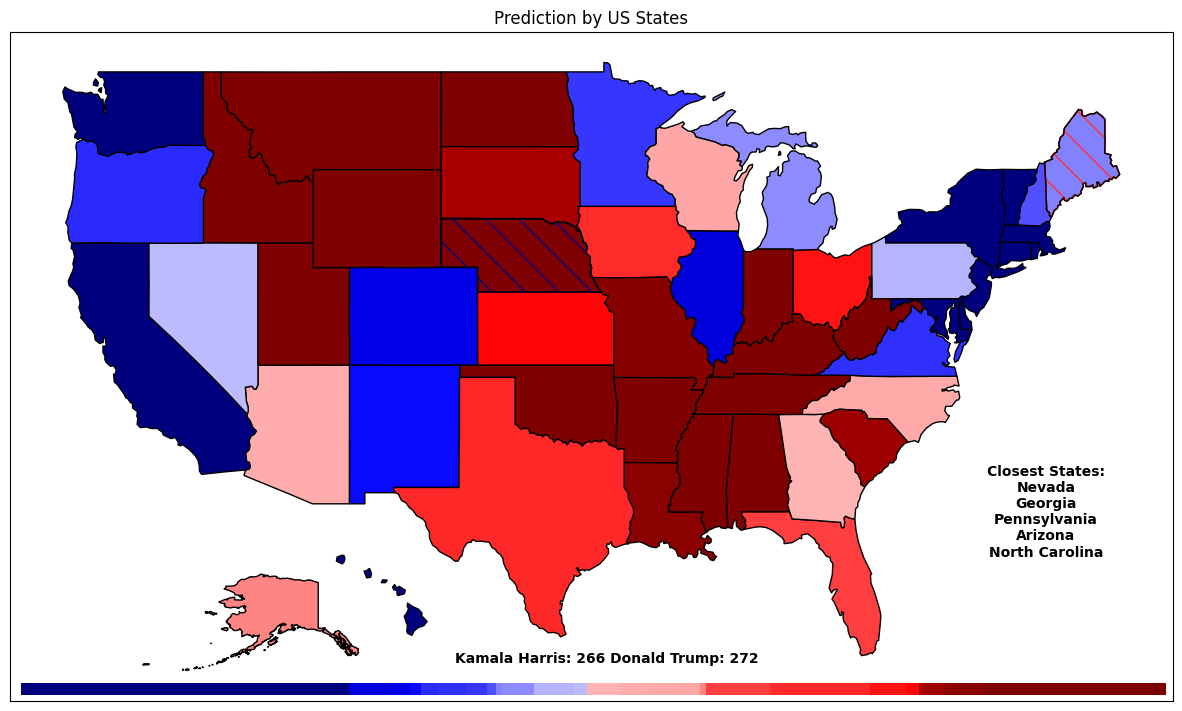

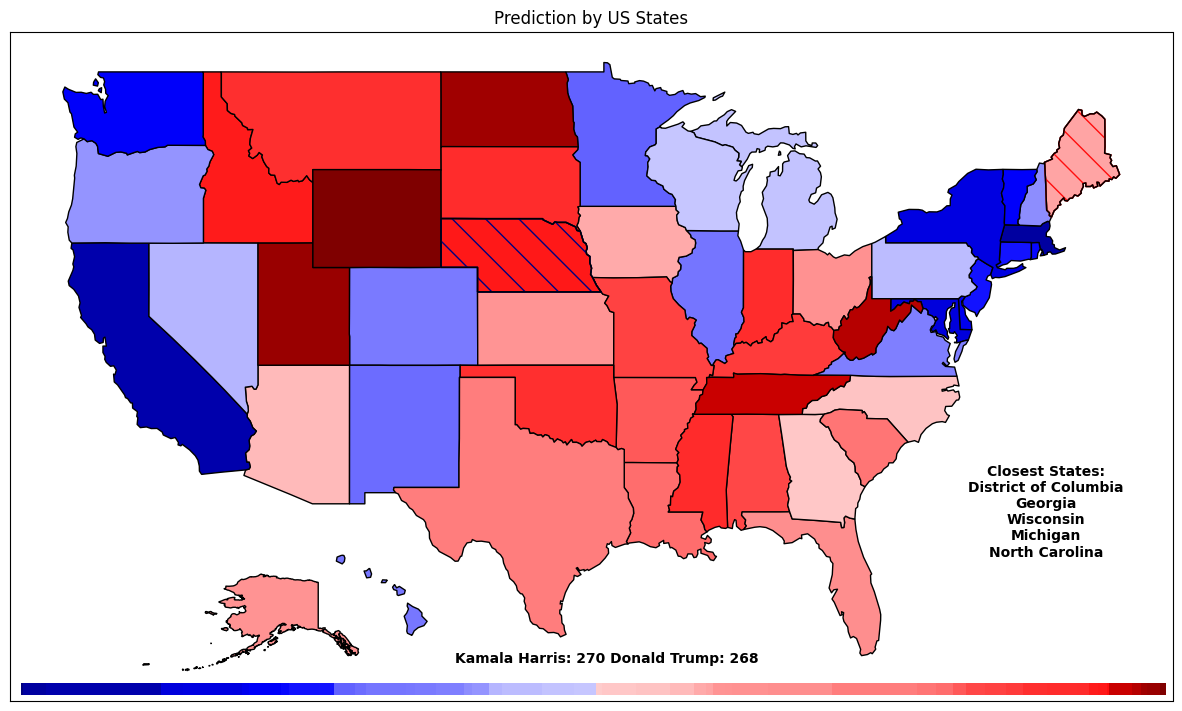

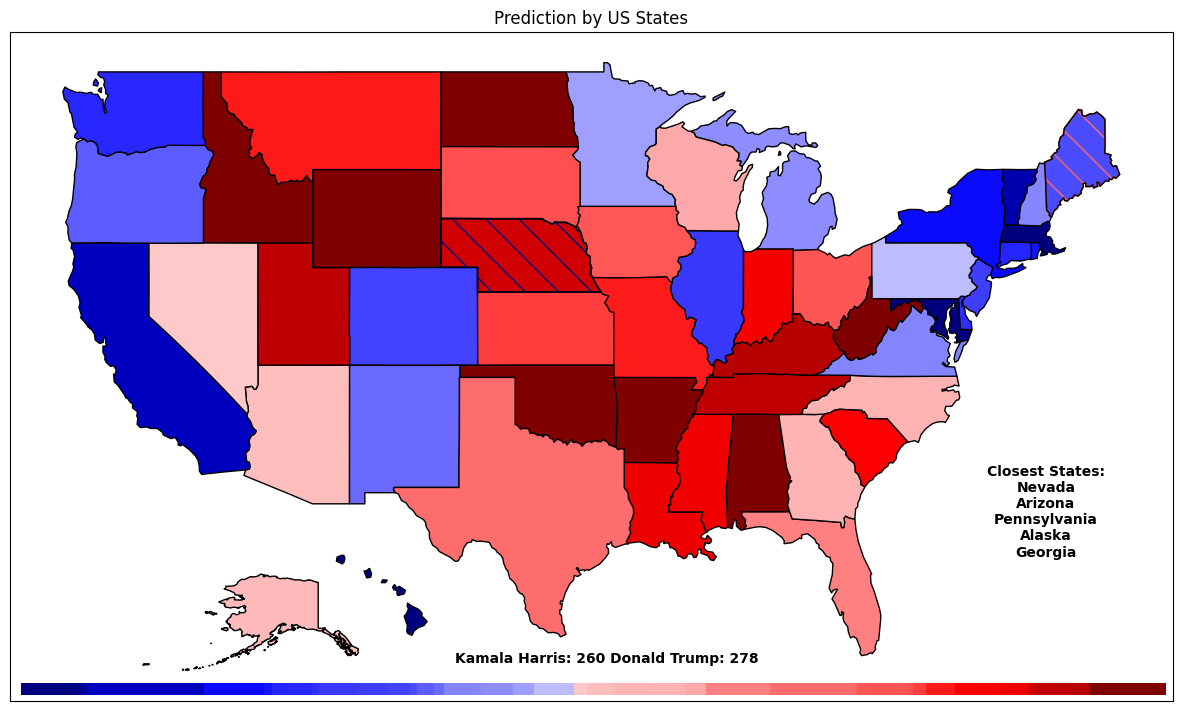

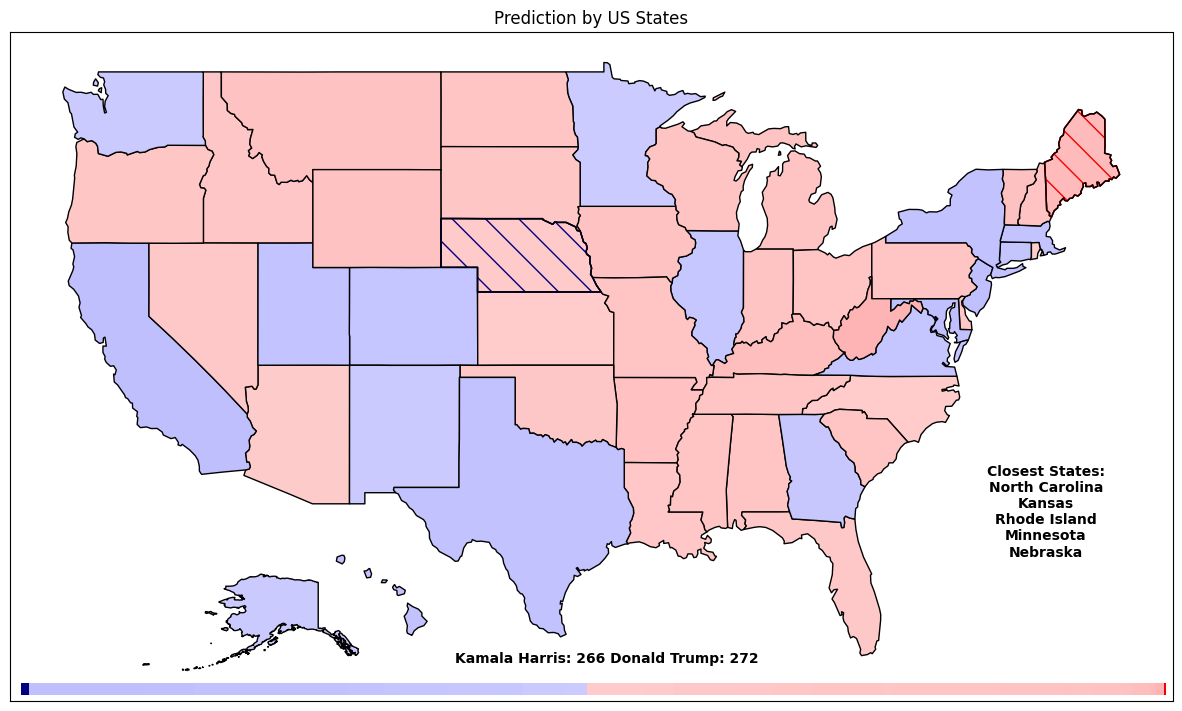

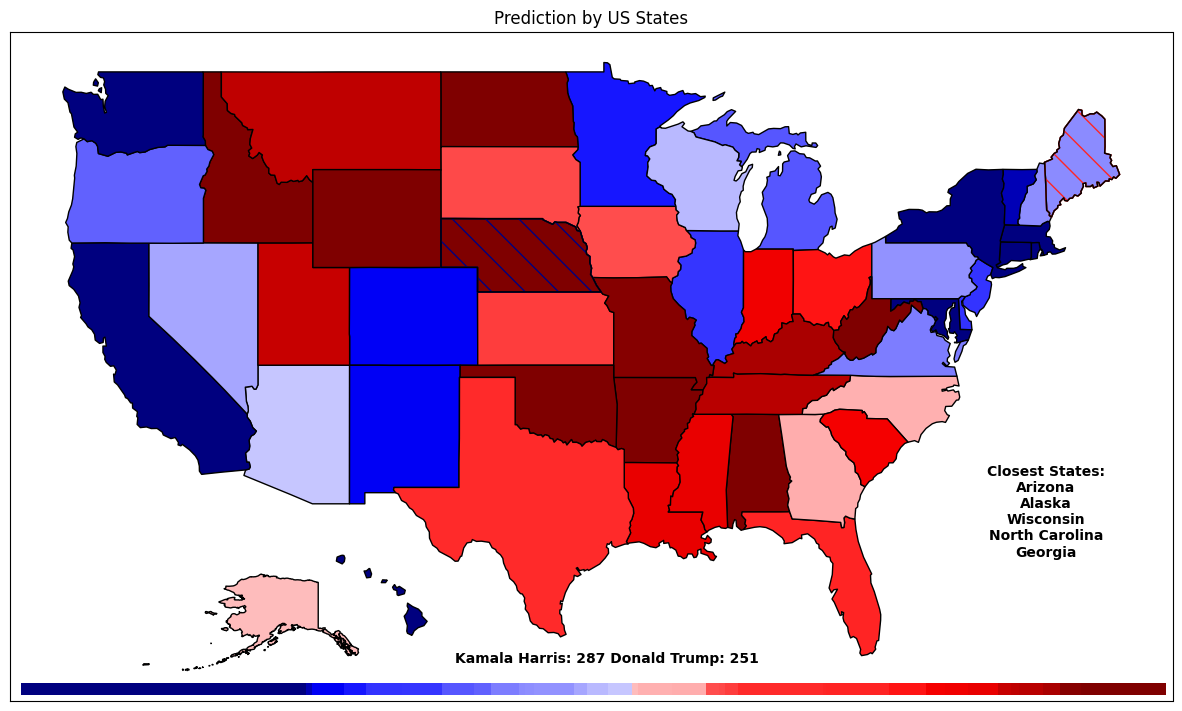

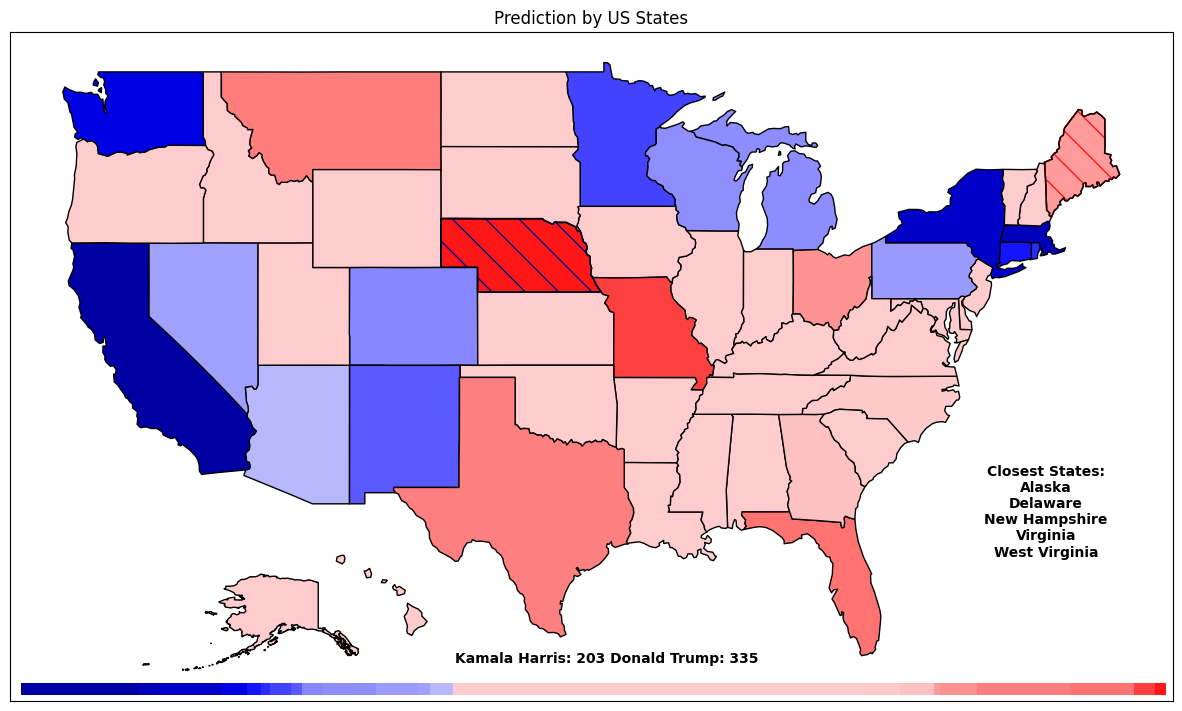

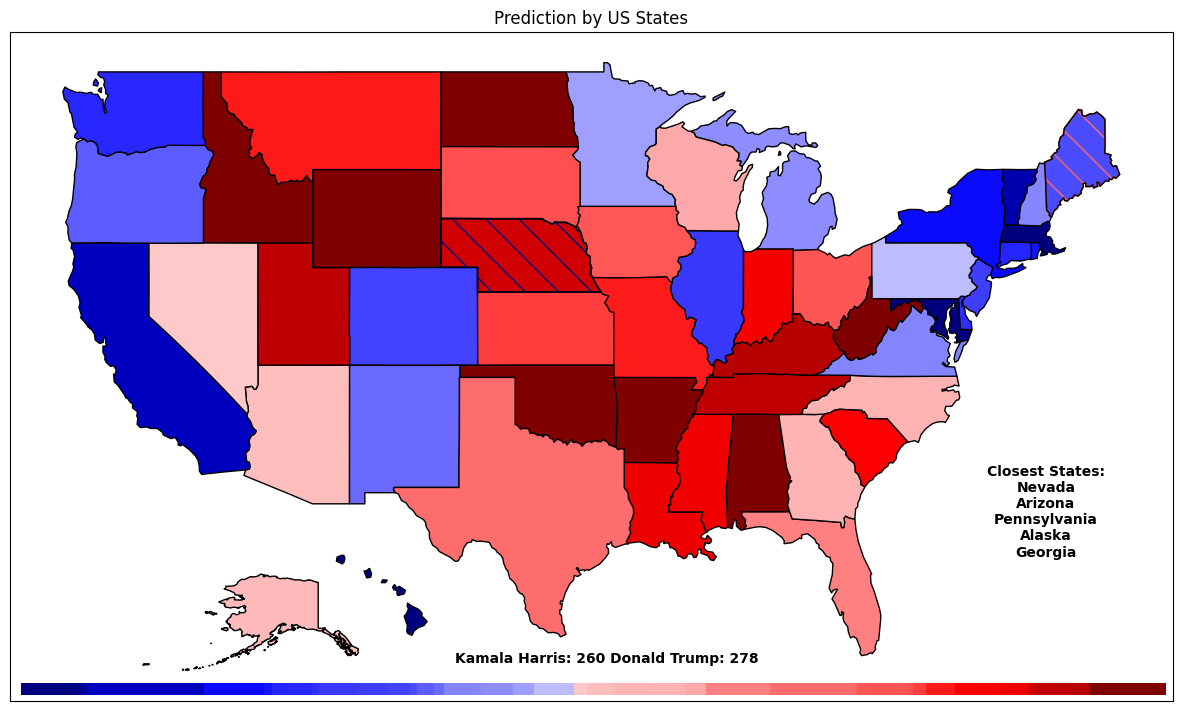

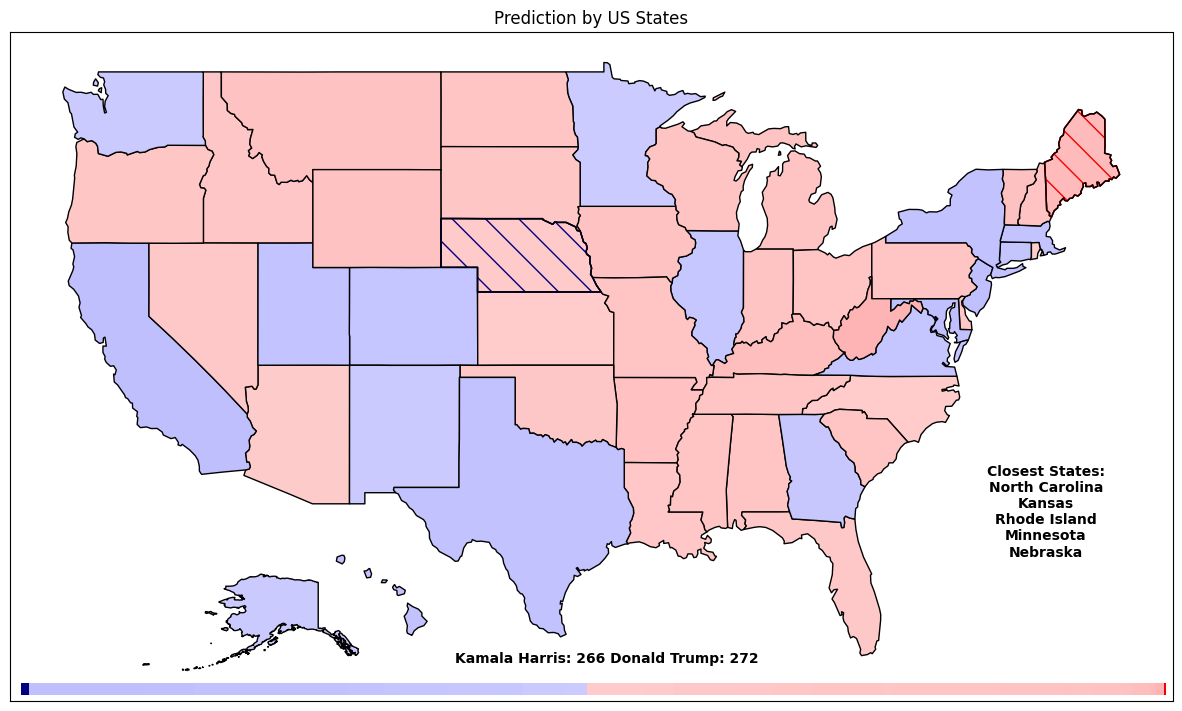

In [ ]:
def saveAll(weights,pollster=False):
    simulateElection(weights=weights,save="Weights-" + weights + "-All" + "OnlyTop20Pollster" + str(pollster),pollster=pollster)
    simulateElection(weights=weights, save="Weights-" + weights + "-Polling" + "OnlyTop20Pollster" + str(pollster),remove_categories=["Result","Demography","Keys"],pollster=pollster)
    simulateElection(weights=weights, save="Weights-" + weights + "-Result",remove_categories=["Poll","Demography","Keys"],pollster=pollster)
    simulateElection(weights=weights, save="Weights-" + weights + "-Demography",remove_categories=["Result","Poll","Keys"],pollster=pollster)



loadDataInitial()

#proposeWeights(2.0)
#simulateElection(weights="1")

saveAll("1")
saveAll("2")
saveAll("2",True)